# CNN cross-validation demo (3 days -> 1 day)

This notebook demonstrates: 
- loading preprocessed windows from `DataProcessor` (3 days input -> 1 day output),
- selecting the 4 sub-metering channels as multi-channel input,
- building time-series folds with `TimeSeriesSplit`,
- running cross-validation training using `cnn_model_yin.CNN` and `cross_validate`,
- plotting per-fold train/val loss and evaluating on the test set.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from cnn_model_yin import CNN, cross_validate, train
import torch
import torch.nn as nn
import random
import os, sys

# load data through the data preprocessor
sys.path.append(os.path.abspath('..'))  # add parent directory to sys.path
from data_cleanup import DataProcessor

# Reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# Instantiate DataProcessor for 3 days -> 1 day
INPUT_STEPS = 24 * 3  # 72 hours
OUTPUT_STEPS = 24 # 24 hours
processor = DataProcessor(input_steps=INPUT_STEPS, output_steps=OUTPUT_STEPS,local_raw_path='../raw-consumption-data.zip')

# This will fetch, clean, resample and window the data (may take a moment)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = processor.load_and_process_data()

print('Shapes:')
print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

In [4]:
# Select the 4 sub-metering channels as input channels
# Based on data_cleanup.py ordering, expected columns after reorder are:
# [Global_active_power, Global_reactive_power, Voltage, Global_intensity,
#  Sub_metering_1, Sub_metering_2, Sub_metering_3, Sub_metering_rest]
# So sub-metering channel indices (0-based) are 4..7
channel_indices = [4,5,6,7]
n_features = X_train.shape[2]
assert max(channel_indices) < n_features, 'Channel indices out of range for X_train features'

X_train_ch = X_train[:, :, channel_indices]  # shape (n_samples, time, 4)
X_val_ch   = X_val[:, :, channel_indices]
X_test_ch  = X_test[:, :, channel_indices]

print('Selected channel shapes:')
print('X_train_ch', X_train_ch.shape, 'y_train', y_train.shape)

Selected channel shapes:
X_train_ch (25832, 72, 4) y_train (25832, 24)


In [5]:
# Create TimeSeriesSplit folds from the training windows (time-aware)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
folds = []
for train_idx, val_idx in tscv.split(X_train_ch):
    Xtr = X_train_ch[train_idx]
    ytr = y_train[train_idx]
    Xval = X_train_ch[val_idx]
    yval = y_train[val_idx]
    folds.append(((Xtr, ytr), (Xval, yval)))

print(f'Constructed {len(folds)} folds. Example fold shapes:')
print('fold0 train X', folds[0][0][0].shape, 'y', folds[0][0][1].shape, 'val X', folds[0][1][0].shape)

Constructed 5 folds. Example fold shapes:
fold0 train X (4307, 72, 4) y (4307, 24) val X (4305, 72, 4)


In [6]:
# Define model factory (callable returning a fresh model)
def make_model():
    return CNN(in_channels=4, input_length=INPUT_STEPS, output_steps=OUTPUT_STEPS)

# Run cross-validation quickly (small epochs for demo)
histories, val_losses = cross_validate(make_model, folds, device=None, epochs=3, batch_size=32, lr=1e-3, verbose=True)

print('Per-fold final val losses:', val_losses)

Starting fold 1/5: train (4307, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.021404 - val_loss: 0.013400
E

Epoch 1/5 - train_loss: 0.017056 - val_loss: 0.013501
Epoch 2/5 - train_loss: 0.013756 - val_loss: 0.012611
Epoch 2/5 - train_loss: 0.013756 - val_loss: 0.012611
Epoch 3/5 - train_loss: 0.013126 - val_loss: 0.012473
Epoch 3/5 - train_loss: 0.013126 - val_loss: 0.012473
Epoch 4/5 - train_loss: 0.012737 - val_loss: 0.012507
Epoch 4/5 - train_loss: 0.012737 - val_loss: 0.012507
Epoch 5/5 - train_loss: 0.012399 - val_loss: 0.012630
Epoch 5/5 - train_loss: 0.012399 - val_loss: 0.012630


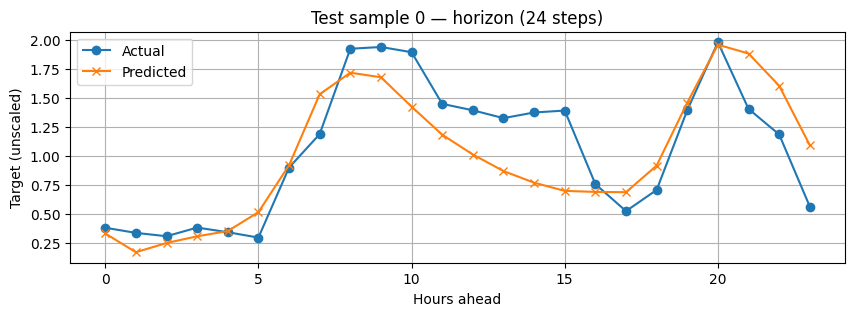

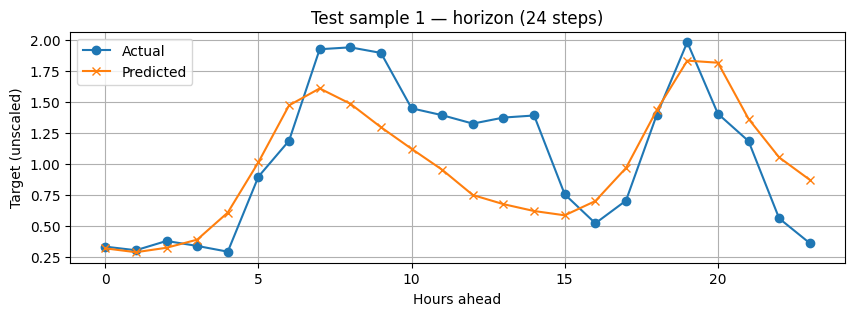

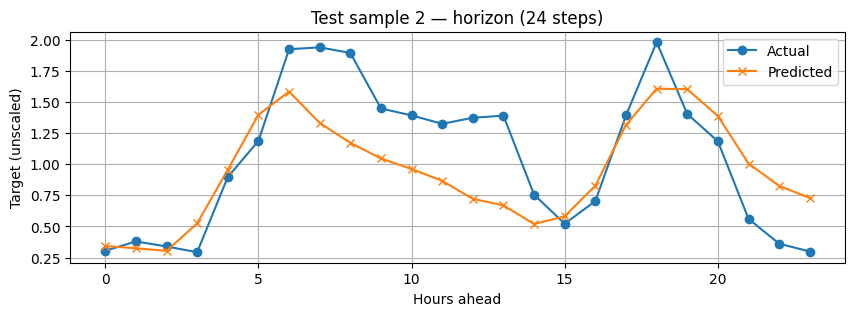

Final test MSE (unscaled, all horizons): 0.452111


In [9]:
# Final quick evaluation: train a model on full training set (train windows) and evaluate on test set
final_model = make_model()
final_hist = train(final_model, X_train_ch, y_train, X_val=X_val_ch, y_val=y_val, device=None, epochs=5, batch_size=32, lr=1e-3, verbose=True)

# Evaluate on test set (ensure tensor shapes and device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_model = final_model.to(device)
final_model.eval()

with torch.no_grad():
    Xt = torch.tensor(X_test_ch, dtype=torch.float32).to(device)
    # Xt expected shape: (N, T, C) or (N, C, T). Convert to (N, C, T) if last dim == channel count (4)
    if Xt.ndim == 3 and Xt.shape[2] == 4 and Xt.shape[1] != 4:
        Xt = Xt.permute(0, 2, 1)
    preds = final_model(Xt)
    yt = torch.tensor(y_test, dtype=torch.float32).to(device)
    preds_np = preds.cpu().numpy()
    yt_np = yt.cpu().numpy()

# Inverse-transform each horizon step separately back to original units using the processor's scaler
# preds_np and yt_np shape: (n_samples, output_steps)
preds_un = np.zeros_like(preds_np)
yt_un = np.zeros_like(yt_np)
for t in range(preds_np.shape[1]):
    try:
        preds_un[:, t] = processor.inverse_transform_predictions(preds_np[:, t])
        yt_un[:, t] = processor.inverse_transform_predictions(yt_np[:, t])
    except Exception as e:
        # If inverse transform fails, fall back to plotting scaled values and warn the user
        print('Warning: inverse transform failed for horizon step', t, '-> plotting scaled values. Error:', e)
        preds_un[:, t] = preds_np[:, t]
        yt_un[:, t] = yt_np[:, t]

# Plot the first K test samples comparing predicted vs actual across the horizon
K = 3
import matplotlib.pyplot as plt
for i in range(min(K, preds_un.shape[0])):
    plt.figure(figsize=(10, 3))
    plt.plot(range(preds_un.shape[1]), yt_un[i], marker='o', label='Actual')
    plt.plot(range(preds_un.shape[1]), preds_un[i], marker='x', label='Predicted')
    plt.title(f'Test sample {i} — horizon ({preds_un.shape[1]} steps)')
    plt.xlabel('Hours ahead')
    plt.ylabel('Target (unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Numeric summary (unscaled MSE across all horizons)
mse_unscaled = np.mean((preds_un - yt_un)**2)
print(f'Final test MSE (unscaled, all horizons): {mse_unscaled:.6f}')

Notes:
- This demo uses small epoch counts so it runs quickly; increase epochs for serious training.
- If your DataProcessor used different column ordering or unit scaling, adjust `channel_indices`.
- For production: add early-stopping, model checkpointing (torch.save), and more metrics (MAE/RMSE).